### Notebook to analyse the results of HS detection on new independant cohort 

In [3]:
import os
import pandas as pd


In [4]:
# load csv with ground truth

info_file = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_H10/aidhs_data_folder/MELD_participants_infos_H10_240404.csv'

df_info = pd.read_csv(info_file)
df_info.head()

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,seizure_free,seizure_free_aura,engel_1yr,ilae_1yr,engel,ilae,follow_up,aeds_post_op,participant_information_complete,hemi
0,1,MELD_H10_P_0001,RMKFDO,1,NaN,NaN,H10,1,0,1.0,...,2.0,2.0,1.0,2.0,2.0,3.0,4.0,1.0,NaN,R
1,2,MELD_H10_P_0002,ARM,1,NaN,NaN,H10,1,1,8.0,...,2.0,2.0,3.0,5.0,3.0,4.0,1.0,1.0,NaN,R
2,3,MELD_H10_P_0003,ELR,1,NaN,NaN,H10,1,0,8.0,...,2.0,2.0,3.0,4.0,4.0,5.0,7.0,1.0,NaN,L
3,4,MELD_H10_P_0004,AAO,1,NaN,NaN,H10,1,1,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,NaN,L
4,5,MELD_H10_P_0005,ADT,1,NaN,NaN,H10,1,1,10.0,...,2.0,1.0,2.0,4.0,1.0,2.0,3.0,1.0,NaN,L


In [9]:
#load subjects list
subjects_file  = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_H10/aidhs_data_folder/list_subjects.csv'

subjects = pd.read_csv(subjects_file)['ID'].values
len(subjects)


108

In [92]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

results_folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_H10/aidhs_data_folder/output/prediction_reports'

df_data = pd.DataFrame()

group_array = []
predictions_array = []
labels_array = []
scores_array = []


for subject in subjects:
    values={}
    values['id'] = subject
    group = df_info[df_info['id']==subject]['patient_control'].values[0]
    if group == 1:
        group = 'P'
        hemi = df_info[df_info['id']==subject]['hemi'].values[0]
        if hemi=='L':
            label = 'left HS'
        elif hemi=='R':
            label = 'right HS'
        else:
            print('Hemisphere not known')
    else:
        label = 'no asymmetry'
        group = 'C'
    values['label'] = label
    values['group'] = group
    
    df_results = pd.read_csv(os.path.join(results_folder, subject, f'{subject}_predictions.csv'))
    values['scores']= df_results[['score no asymmetry', 'score left HS', 'score right HS']].values[0]
    values['prediction'] = df_results['prediction'].values[0]

    df_data = pd.concat([df_data, pd.DataFrame([values])])
df_data.head()

,id,label,group,scores,prediction
0,MELD_H10_P_0004,left HS,P,"[0.0176702109970134, 0.9823294594639136, 3.295...",left HS
0,MELD_H10_P_0005,left HS,P,"[1.0730186931923891e-05, 0.999989269813068, 1....",left HS
0,MELD_H10_P_0006,right HS,P,"[0.0841844324555327, 0.000280380747468, 0.9155...",right HS
0,MELD_H10_P_0007,right HS,P,"[0.0005346313559846, 2.7013784145969066e-08, 0...",right HS
0,MELD_H10_P_0008,left HS,P,"[0.0086076555098419, 0.9913923440820523, 4.081...",left HS


In [87]:
# Encode data class and prediction
import numpy as np
from sklearn.preprocessing import label_binarize

dict_labels = {'no asymmetry':0,
               'left HS':1,
               'right HS':2}
Y = np.array([dict_labels[x] for x in df_data['label'].values])
y_pred = np.array([dict_labels[x] for x in df_data['prediction'].values])
scores =  np.array([x for x in df_data['scores']])

#Binarize the output
y_bin = label_binarize(Y, classes=np.arange(len(set(Y))))

print('number ipsi lh: ' + str(len(np.where(Y==1)[0])))
print('number ipsi rh: ' + str(len(np.where(Y==2)[0])))
print('number control: ' + str(len(np.where(Y==0)[0])))


number ipsi lh: 31
number ipsi rh: 23
number control: 54


In [93]:
# compute results lateralisation and detection
from aidhs.train_evaluate import compute_performances, get_lateralisation_performances, get_differentiation_performances

#COMPUTE PERFORMANCES
results = compute_performances(Y, y_bin, y_pred, scores)
    
#add lateralisation performances
results['predict_side'], results['accurately_lateralised'], results['scores_lateralised'] = get_lateralisation_performances(Y, scores)

#add detection performances
results['predict_group'], results['accurately_differentiated'], results['scores_differentiated'] = get_differentiation_performances(Y, scores)
    

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        54
           1       0.96      0.81      0.88        31
           2       1.00      1.00      1.00        23

    accuracy                           0.94       108
   macro avg       0.95      0.93      0.94       108
weighted avg       0.94      0.94      0.93       108



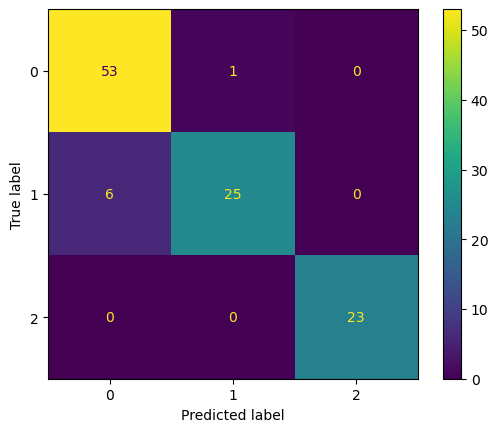

In [94]:
# plot confusion matrix
print(classification_report(Y,results['predictions']))
cm = confusion_matrix(Y,results['predictions'])
ConfusionMatrixDisplay(cm).plot()

In [95]:
#comparison of overall performances per methods

try:
    print('\nPerformances lateralisation only:')
    df_data[f'TP_side'] = results['accurately_lateralised']
    
    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_side']==True)])
        print(f'TP in HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

except:
    pass

try:
    print('\nPerformances differentiation only:')
    df_data[f'TP_group'] = results['accurately_differentiated']

    n_tot = len(df_data)
    if n_tot>0:
        n_tp = len(df_data[(df_data['TP_group']==True)])
        print(f'TP differentiating: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[df_data['group']!='P'])
    if n_tot>0:
        n_tp = len(df_data[(df_data['group']!='P')&(df_data['TP_group']==True)])
        print(f'TP detecting controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_group']==True)])
        print(f'TP detecting HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in HS: 53/54 (98.1%)

Performances differentiation only:
TP differentiating: 101/108 (93.5%)
TP detecting controls: 53/54 (98.1%)
TP detecting HS: 48/54 (88.9%)


In [28]:
# find results 
detected = np.array(predictions_array)==np.array(labels_array)

subjects_fp = subjects[detected==False]

In [29]:
subjects_fp

array(['MELD_H10_P_0011', 'MELD_H10_P_0033', 'MELD_H10_P_0041',
       'MELD_H10_P_0042', 'MELD_H10_P_0045', 'MELD_H10_P_0053',
       'MELD_H10_C_0018'], dtype=object)

In [35]:
df_info[df_info['id']=='MELD_H10_P_0045']

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,seizure_free,seizure_free_aura,engel_1yr,ilae_1yr,engel,ilae,follow_up,aeds_post_op,participant_information_complete,hemi
44,45,MELD_H10_P_0045,NCF,1,NaN,NaN,H10,1,0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,L
